# Data exploration

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
wholesale = pd.read_csv('wholesale.csv')

In [110]:
# Drop the unrelated columns 
wholesale.drop(['Region', 'Channel'], axis = 1, inplace = True)

In [111]:
print(wholesale.head())

   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0  12669  9656     7561     214              2674        1338
1   7057  9810     9568    1762              3293        1776
2   6353  8808     7684    2405              3516        7844
3  13265  1196     4221    6404               507        1788
4  22615  5410     7198    3915              1777        5185


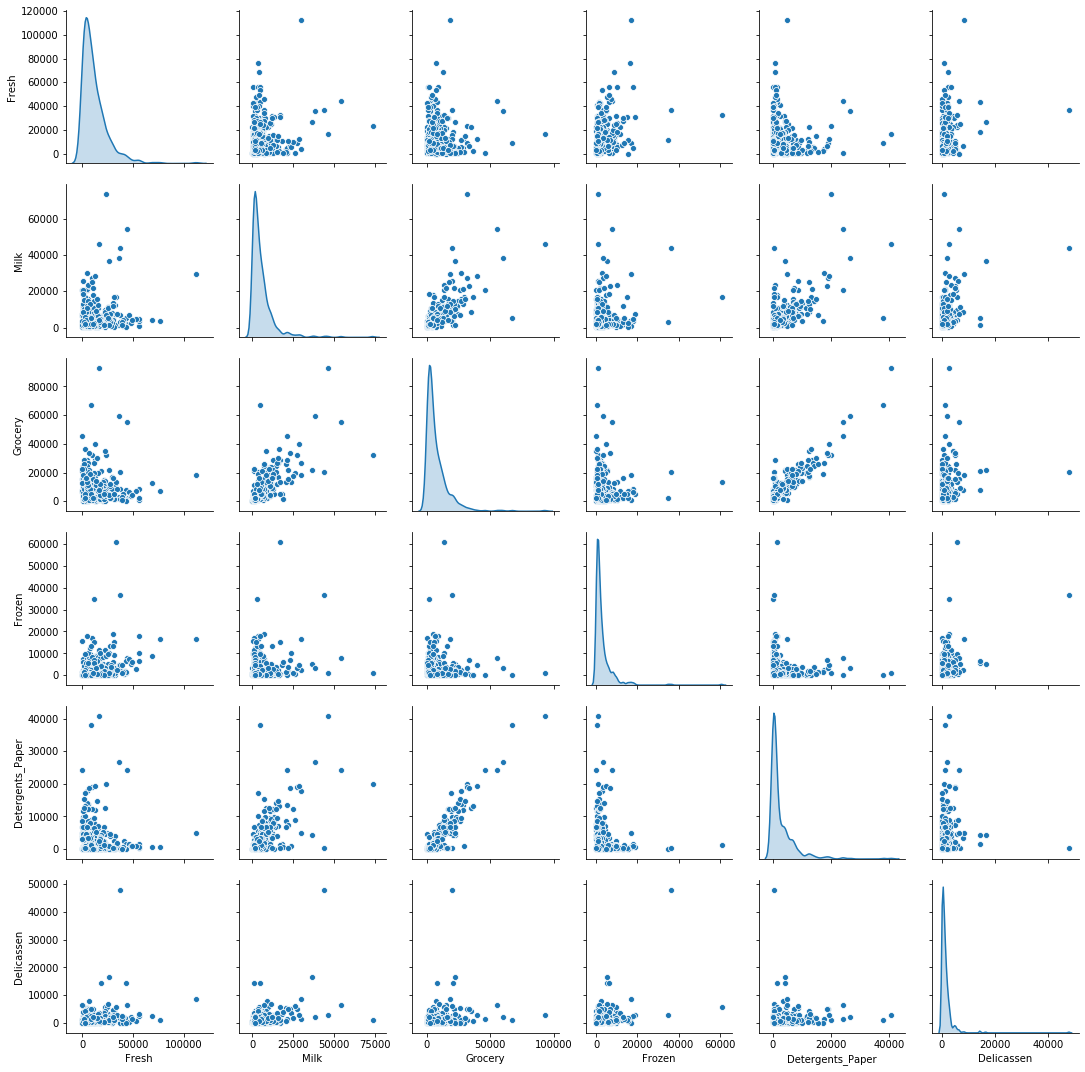

In [112]:
# Plot the pairwise relationships
sns.pairplot(wholesale, diag_kind='kde')
plt.show()

In [113]:
# Display the description of the dataset
display(wholesale.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [114]:
# Create column names list and same length integer list
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

In [115]:
# Create series of averages and standard deviations
averages = wholesale.mean()
std_devs = wholesale.std()

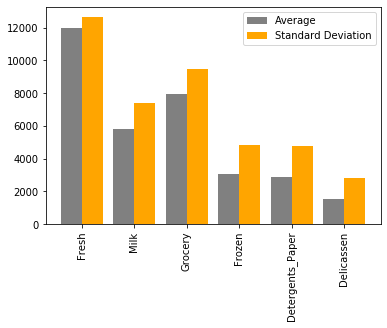

In [116]:
# Plot the average and standard deviation of the dataset
plt.bar(x=x_ix-0.2, height=averages, color='grey', label='Average', width=0.4)
plt.bar(x=x_ix+0.2, height=std_devs, color='orange', label='Standard Deviation', width=0.4)
plt.xticks(ticks=x_ix, labels=x_names, rotation=90)
plt.legend()
plt.show()

# Data preparation for segmentations

### Unskew data

In [117]:
# K-means clustering assuptions: 1)normally distributed 2)standardized(mean=0,std=1)
# Non-negative matrix factorization(NMF): can be used on raw data especially if the matrix is sparse

In [118]:
# Unskew data with log-transformation
#wholesale_log = np.log(wholesale)
#sns.pairplot(wholesale_log, diag_kind='kde')
#plt.show()

In [119]:
# Unskew data with box-cox transformation
def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox

wholesale_boxcox = wholesale.apply(boxcox_df, axis=0)

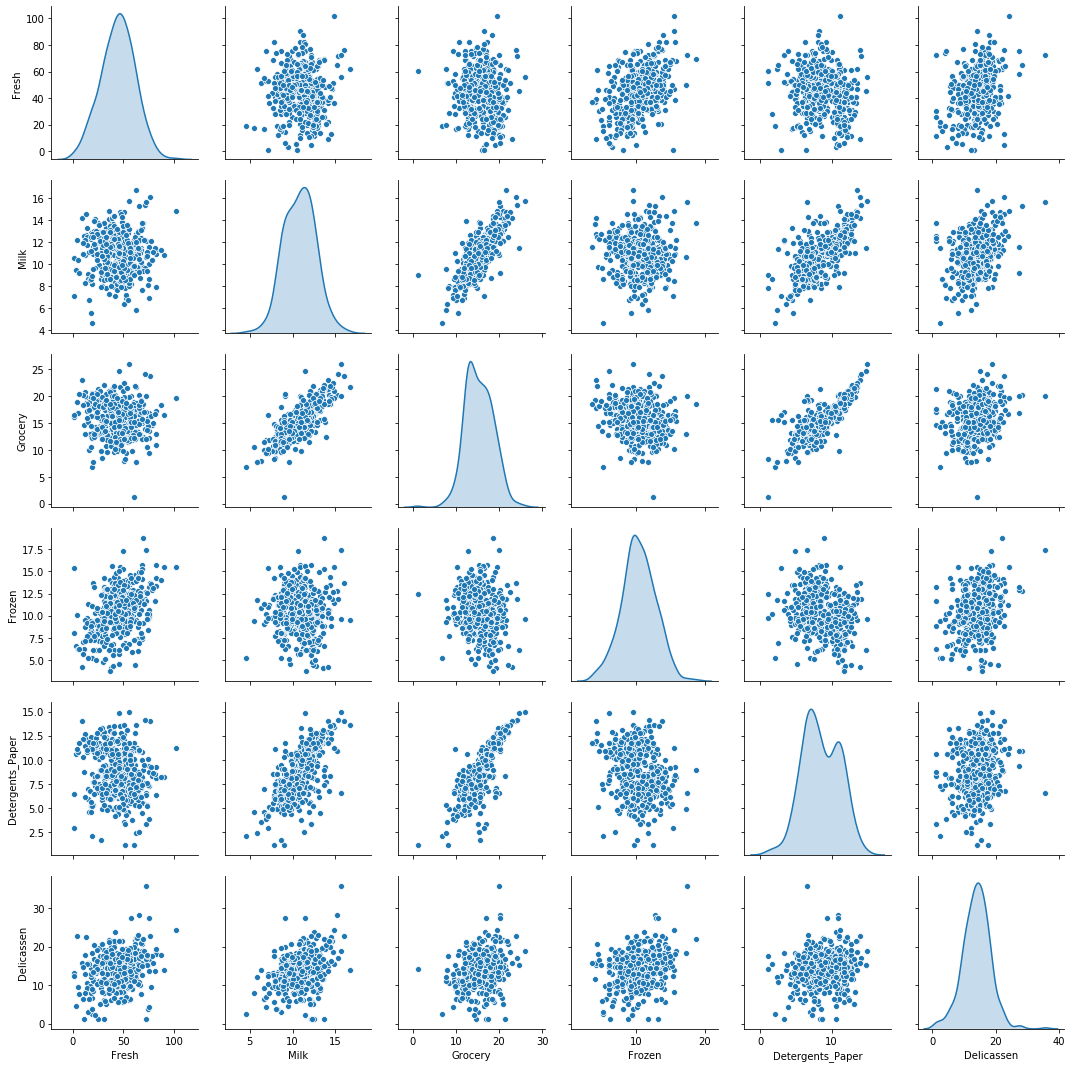

In [120]:
sns.pairplot(wholesale_boxcox, diag_kind='kde')
plt.show()

### Normalize the variables

In [121]:
# Fit initialized scaler on the box-cox transformed dataset
scaler = StandardScaler()
scaler.fit(wholesale_boxcox)

# Transform and store the scaled dataset
wholesale_scaled = scaler.transform(wholesale_boxcox)

In [122]:
# Create a pandas dataframe 
wholesale_scaled_df = pd.DataFrame(data=wholesale_scaled,
                                   index=wholesale_boxcox.index,
                                   columns=wholesale_boxcox.columns)

In [123]:
# Print the mean and standard deviation for all columns
print(wholesale_scaled_df.agg(['mean','std']).round())

      Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
mean   -0.0   0.0     -0.0    -0.0              -0.0         0.0
std     1.0   1.0      1.0     1.0               1.0         1.0


# Build customer and product segmentation

### Determine the optimal number of clusters

In [124]:
# Create empty SSE dictionary
sse = {}

In [125]:
# Fit KMeans algorithm on k values from 1 to 11
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(wholesale_scaled_df)
    sse[k] = kmeans.inertia_

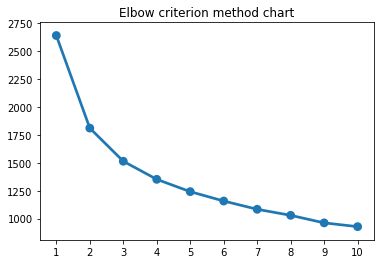

In [126]:
# Plot the results of sse for each k
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title('Elbow criterion method chart')
plt.show()

# The optimal number of clusters is 4 as 4 is at the 'elbow' - diminishing incremental improvements in error reduction

### Build segmentation with k-means clustering

In [127]:
# Initialize KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=123)

In [128]:
# Fit the model on the dataset
kmeans.fit(wholesale_scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [129]:
# Assign the generated labels to a new column
wholesale_kmeans3 = wholesale.assign(segment=kmeans.labels_)

### Build segmentation with NMF

In [130]:
# Initialize NMF with 4 components 
nmf = NMF(4)

In [131]:
# Fit the model on the wholesale dataset 
nmf.fit(wholesale)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [132]:
# Extract the components
components = pd.DataFrame(data=nmf.components_, columns=wholesale.columns)

# Visualize and interpret segmentation solutions

### K-means segmentation averages

In [136]:
# Group by the segment label and calculate average column values
kmeans3_averages = wholesale_kmeans3.groupby(['segment']).mean().round(0)
print(kmeans3_averages)

           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen
segment                                                                 
0         9421.0   1984.0   2504.0  2301.0             439.0       640.0
1         6718.0  10354.0  15937.0  1323.0            7107.0      1409.0
2        23708.0   5813.0   5916.0  6808.0            1067.0      3169.0


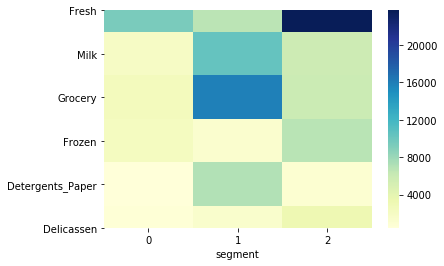

In [144]:
# Create a heatmap on the average column values per each segment
sns.heatmap(kmeans3_averages.T, cmap='YlGnBu')
plt.show()

### NMF segmentation averages

In [147]:
# Create the W matrix 
W = pd.DataFrame(data=nmf.transform(wholesale), columns=components.index)
W.index = wholesale.index 

In [148]:
# Assign the column name where the corresponding value is the largest
wholesale_nmf3 = wholesale.assign(segment = W.idxmax(axis=1))

In [149]:
# Calculate the average column values per each segment
nmf3_averages = wholesale_nmf3.groupby('segment').mean().round(0)

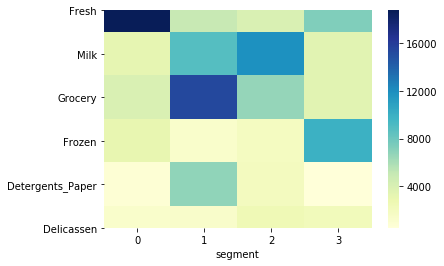

In [150]:
# Plot the average values as heatmap
sns.heatmap(nmf3_averages.T, cmap='YlGnBu')
plt.show()